pylint: disable=import-error

In [1]:
from __future__ import annotations
from pathlib import Path
import matplotlib.pyplot as plt  # type: ignore
import networkx as nx  # type: ignore
import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import seaborn as sns  # type: ignore
from scipy.cluster.hierarchy import dendrogram, linkage  # type: ignore
from scipy.spatial.distance import pdist, squareform  # type: ignore
from seaborn import load_dataset  # type: ignore
import json
from urllib.request import Request, urlopen

In [2]:
NUMERIC_COLS = [
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
]

In [3]:
df = load_dataset("penguins")[NUMERIC_COLS + ["species"]].dropna().reset_index(drop=True)

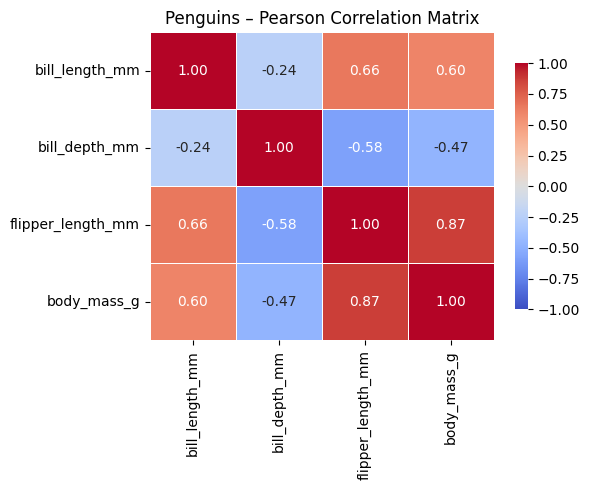

In [4]:
corr = df[NUMERIC_COLS].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Penguins – Pearson Correlation Matrix")
plt.tight_layout()
plt.show()
plt.close()

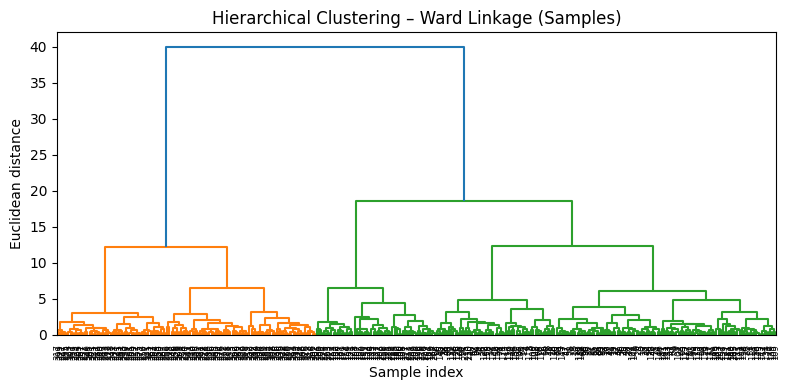

In [5]:
zscored = (df[NUMERIC_COLS] - df[NUMERIC_COLS].mean()) / df[NUMERIC_COLS].std()
linkage_matrix = linkage(zscored, method="ward")
plt.figure(figsize=(8, 4))
dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90, leaf_font_size=6)
plt.title("Hierarchical Clustering – Ward Linkage (Samples)")
plt.xlabel("Sample index")
plt.ylabel("Euclidean distance")
plt.tight_layout()
plt.show()
plt.close()

In [6]:
threshold= 0.7
corr = df[NUMERIC_COLS].corr()
G = nx.Graph()
for col in NUMERIC_COLS:
    G.add_node(col)

for i, col_i in enumerate(NUMERIC_COLS):
    for col_j in NUMERIC_COLS[i + 1 :]:
        rho = corr.loc[col_i, col_j]
        if abs(rho) >= threshold:
            G.add_edge(col_i, col_j, weight=abs(rho), sign=np.sign(rho))

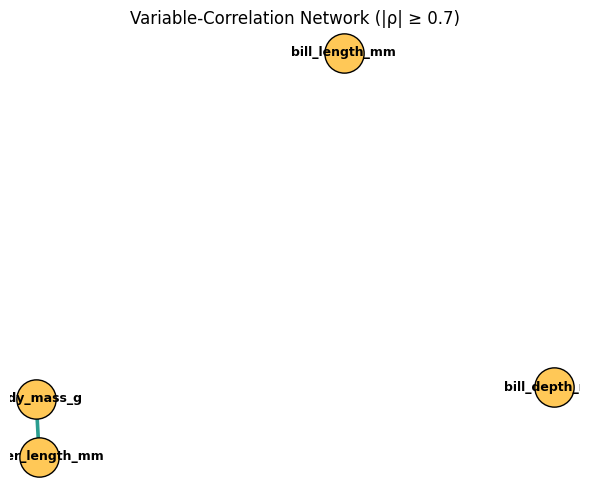

In [7]:
pos = nx.spring_layout(G, seed=42)
weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
signs = np.array([G[u][v]["sign"] for u, v in G.edges()])

plt.figure(figsize=(6, 5))
nx.draw_networkx_nodes(G, pos, node_size=800, node_color="#FFC857", edgecolors="k")
pos_mask = signs > 0
neg_mask = signs < 0
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=np.array(G.edges())[pos_mask].tolist(),
    width=3 * weights[pos_mask],
    edge_color="#2A9D8F",
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=np.array(G.edges())[neg_mask].tolist(),
    width=3 * weights[neg_mask],
    edge_color="#E76F51",
    style="dashed",
)
# Labels
nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")
plt.title("Variable-Correlation Network (|ρ| ≥ 0.7)")
plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()

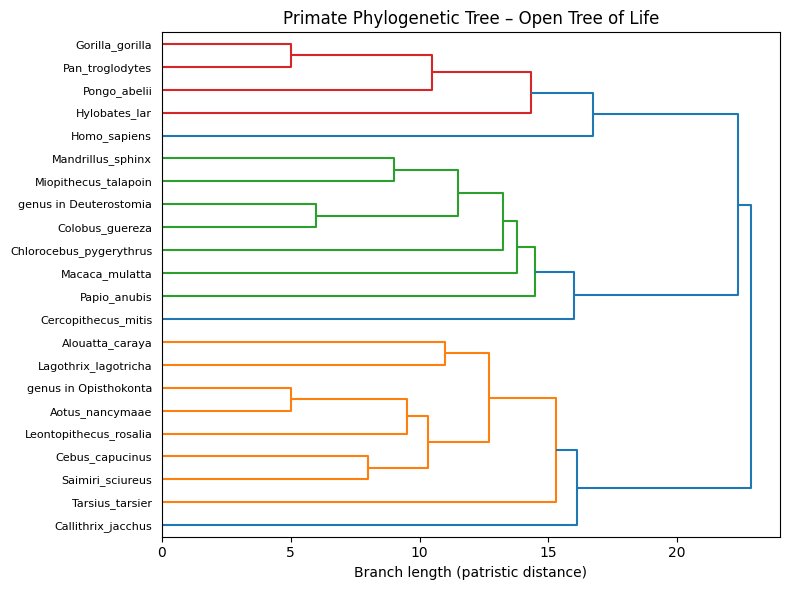

In [8]:
species = [
    "Homo sapiens",
    "Pan troglodytes",
    "Gorilla gorilla",
    "Pongo abelii",
    "Macaca mulatta",
    "Papio anubis",
    "Mandrillus sphinx",
    "Hylobates lar",
    "Cercopithecus mitis",
    "Colobus guereza",
    "Miopithecus talapoin",
    "Chlorocebus pygerythrus",
    "Saimiri sciureus",
    "Callithrix jacchus",
    "Cebus capucinus",
    "Alouatta caraya",
    "Aotus nancymaae",
    "Leontopithecus rosalia",
    "Lagothrix lagotricha",
    "Tarsius tarsier",
]

def post_json(url: str, payload: dict) -> dict:
    req = Request(url, data=json.dumps(payload).encode(), headers={"Content-Type": "application/json"})
    with urlopen(req, timeout=30) as resp:
        return json.load(resp)

match_url = "https://api.opentreeoflife.org/v3/tnrs/match_names"
match_res = post_json(match_url, {"names": species})

ott_ids: list[int] = []
for item in match_res.get("results", []):
    matches = item.get("matches", [])
    if matches:
        ott_ids.append(matches[0]["taxon"]["ott_id"])

if len(ott_ids) < 2:  # pragma: no cover – network failure fallback
    raise RuntimeError("Failed to resolve species names via OpenTree API.")

subtree_url = "https://api.opentreeoflife.org/v3/tree_of_life/induced_subtree"
try:
    subtree_res = post_json(subtree_url, {"ott_ids": ott_ids, "label_format": "name"})
except Exception as exc:  # pragma: no cover – network failure fallback
    raise RuntimeError("OpenTree induced_subtree request failed") from exc
newick: str = subtree_res["newick"]


class Node:
    __slots__ = ("name", "length", "children", "parent")

    def __init__(self, name: str | None = None, length: float = 0.0):
        self.name = name
        self.length = length
        self.children: list["Node"] = []
        self.parent: "Node | None" = None

def parse_newick(s: str) -> Node:
    idx = 0

    def parse_subtree() -> Node:
        nonlocal idx
        if s[idx] == "(":
            idx += 1  # consume "("
            children: list[Node] = []
            while True:
                child = parse_subtree()
                children.append(child)
                if s[idx] == ",":
                    idx += 1
                    continue
                elif s[idx] == ")":
                    idx += 1  # consume ")"
                    break
            name, length = parse_name_length()
            node = Node(name, length)
            node.children = children
            for ch in children:
                ch.parent = node
            return node
        else:
            name, length = parse_name_length()
            return Node(name, length)

    def parse_name_length() -> tuple[str | None, float]:
        nonlocal idx
        name_chars: list[str] = []
        while idx < len(s) and s[idx] not in ":,()":
            name_chars.append(s[idx])
            idx += 1
        name = "".join(name_chars).strip() or None
        length = 0.0
        if idx < len(s) and s[idx] == ":":
            idx += 1
            num_chars: list[str] = []
            while idx < len(s) and s[idx] not in ",()":
                num_chars.append(s[idx])
                idx += 1
            try:
                length = float("".join(num_chars))
            except ValueError:
                length = 1.0
        else:
            length = 1.0
        return name, length

    root = parse_subtree()
    return root

newick = newick.rstrip(";\n ")
root_node = parse_newick(newick)

leaves: list[Node] = []

def collect_leaves(node: Node):
    if not node.children:
        leaves.append(node)
    for ch in node.children:
        collect_leaves(ch)

collect_leaves(root_node)

leaf_names = [leaf.name or f"leaf_{i}" for i, leaf in enumerate(leaves)]

def distance_to_root(node: Node) -> float:
    dist = 0.0
    while node.parent is not None:
        dist += node.length
        node = node.parent
    return dist

root_dists = {leaf: distance_to_root(leaf) for leaf in leaves}

def path_length(a: Node, b: Node) -> float:
    visited: dict[Node, float] = {}
    dist = 0.0
    node = a
    while node is not None:
        visited[node] = dist
        dist += node.length
        node = node.parent

    dist = 0.0
    node = b
    while node not in visited:
        dist += node.length
        node = node.parent
    return dist + visited[node]

n_leaves = len(leaves)
dist_mat = np.zeros((n_leaves, n_leaves))
for i in range(n_leaves):
    for j in range(i + 1, n_leaves):
        d = path_length(leaves[i], leaves[j])
        dist_mat[i, j] = dist_mat[j, i] = d

dist_vec = squareform(dist_mat)
Z = linkage(dist_vec, method="average")

plt.figure(figsize=(8, 6))
dendrogram(Z, labels=leaf_names, orientation="right", leaf_font_size=8)
plt.title("Primate Phylogenetic Tree – Open Tree of Life")
plt.xlabel("Branch length (patristic distance)")
plt.ylabel("")
plt.tight_layout()
plt.show()
plt.close()